In [ ]:
!pip install tensorflow

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.1 MB/s eta 0:00:00


In [ ]:
from os import listdir
import numpy as np
from numpy import savez_compressed
import os
from os import listdir
import cv2
from numpy import asarray, vstack, savez_compressed
from numpy.random import randint
from glob import glob
from random import random
from tqdm import tqdm
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from keras.layers import ReLU, Input,Conv2D,Dropout,LeakyReLU, Activation, Concatenate, Conv2DTranspose
from keras.models import load_model,Model ,Sequential
from tensorflow_addons.layers import InstanceNormalization
from keras.initializers import RandomNormal
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam


In [ ]:
import os

def load_images(path, size=(64, 64), max_images=None):
    data_list = []
    for filename in os.listdir(path):
        if filename.endswith('.jpg'):  # Filter for specific image file extensions
            img_path = os.path.join(path, filename)
            pixels = load_img(img_path, target_size=size)
            pixels = img_to_array(pixels)
            data_list.append(pixels)
            if max_images and len(data_list) >= max_images:
                break
    return np.asarray(data_list)

color_path = "/content/drive/MyDrive/color"
gray_path = "/content/drive/MyDrive/gray"

dataA = load_images(color_path, max_images=25)
print('loaded dataA', dataA.shape)

dataB = load_images(gray_path, max_images=25)
print('loaded dataB', dataB.shape)

filename = 'gray2colour.npz'
np.savez_compressed(filename, dataA=dataA, dataB=dataB)

print('Saved dataset:', filename)

loaded dataA (25, 64, 64, 3)
loaded dataB (25, 64, 64, 3)
Saved dataset: gray2colour.npz


Loaded data: (25, 64, 64, 3) (25, 64, 64, 3)


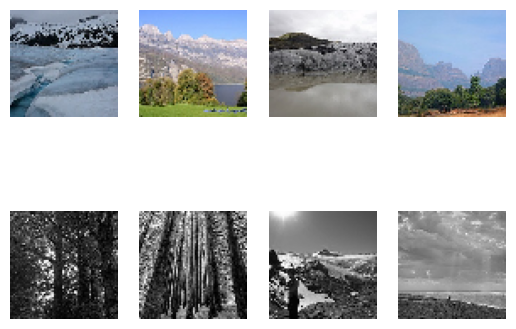

In [ ]:

from numpy import load
data = load('gray2colour.npz')
daraA, dataB = data['dataA'], data['dataB']
print('Loaded data:', dataA.shape, dataB.shape)
n_samples = 4
# plot original image
for i in range (n_samples):
    plt.subplot(2 , n_samples,1+i )
    plt.axis('off')
    plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range (n_samples):
    plt.subplot(2 , n_samples,1+n_samples+i )
    plt.axis('off')
    plt.imshow(dataB[i].astype('uint8'))
plt.show()

In [ ]:
#define the discriminator model
def define_discriminator(image_shape):
    #weight initialization
    init = RandomNormal(stddev = 0.02)
    #source image input
    input_image = Input(shape = image_shape)
    #c64
    x = Conv2D(64,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(input_image)
    x = LeakyReLU(alpha = 0.2)(x)
    #c128
    x = Conv2D(128,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #c256
    x = Conv2D(256,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #c512
    x = Conv2D(512,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)

    x = Conv2D(512,(4,4) , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)

    out_put = Conv2D(1, (4, 4), padding='same', kernel_initializer=init, use_bias=False)(x)

    model = Model(input_image, out_put)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])

    return model

image_shape = (64, 64, 3)
discriminator = define_discriminator(image_shape)
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 instance_normalization (In  (None, 16, 16, 128)       256       
 stanceNormalization)                                            
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                             

In [ ]:
def resnet_block(filters, layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)

    #print(layer.shape)  # print the shape of the previous layer

    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(layer)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)

    # skip connection
    x = Concatenate()([x, layer])
    return x


In [ ]:
def downsample(filters, layer, size=3, strides=2, activation=None, index=None, norm=True):
    x = Conv2D(filters, kernel_size=size, strides=strides, padding ='same', kernel_initializer='he_normal', use_bias=False)(layer)
    x = InstanceNormalization(axis=-1)(x)
    x = LeakyReLU()(x)
    return x

In [ ]:
# define the generator model
def define_generator(image_shape, n_resnet=9):
    #weight initialization
    init = RandomNormal(stddev = 0.02)
    #source image input
    input_image = Input(shape = image_shape)
    #c64
    x = Conv2D(64,(7,7) , padding = 'same', kernel_initializer = init)(input_image)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    #c128
    x = Conv2D(128,(3,3), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    #c256
    x = Conv2D(256,(3,3), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)

    for i in range(n_resnet):
        x = resnet_block(256 , x)

    # Add Conv2DTranspose layers to upscale the image to the desired shape
    x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = Conv2D(3, (7, 7), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    out_image = Activation('tanh')(x)

    model = Model(input_image, out_image)
    return model
image_shape = (64, 64, 3)
generator = define_generator(image_shape)
generator.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 64, 64, 64)           9472      ['input_2[0][0]']             
                                                                                                  
 instance_normalization_4 (  (None, 64, 64, 64)           128       ['conv2d_6[0][0]']            
 InstanceNormalization)                                                                           
                                                                                                  
 activation (Activation)     (None, 64, 64, 64)           0         ['instance_normalization

In [ ]:
from keras.layers import Lambda, Reshape

def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False

    # Input for generated images
    input_gen = Input(shape=image_shape)

    # Resize generated images to the shape expected by the discriminator
    resized_gen = Lambda(lambda x: tf.image.resize(x, (64, 64), method=tf.image.ResizeMethod.BILINEAR))(input_gen)

    # Forward pass through the generator and discriminator
    gen_1_out = g_model_1(resized_gen)
    output_d = d_model(gen_1_out)

    # Input for identity mapping
    input_id = Input(shape=image_shape)

    # Forward pass for identity mapping
    output_id = g_model_1(input_id)

    # Forward and backward cycle loss
    output_f = g_model_2(gen_1_out)
    gen_2_out = g_model_2(input_id)
    output_b = g_model_1(gen_2_out)

    # Define the composite model
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])

    opt = Adam(learning_rate=0.0002, beta_1=0.5)

    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)

    return model

In [ ]:
def load_real_samples(filename):
    data = load(filename)
    X1,X2 = data['dataA'],data['dataB']
    X1 = (X1-127.5)/127.5 #for source image
    X2 = (X2-127.5)/127.5 # for corresponding target images
    return [X1,X2]

In [ ]:
import random

def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0,dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y

In [ ]:
##select a batch of random samples,return images and target
def generate_fake_samples(g_model, dataset, patch_shape):
    # Generate a batch of random noise as input for the generator
    X = g_model.predict(dataset)

    # Create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape,patch_shape, 1))

    return X, y

In [ ]:

#save the generator model to file
def save_models(step, g_model_AtoB, g_model_BtoA):
    filename1 = 'g_model_AtoB_%06d.h5' %(step +1)
    g_model_AtoB.save(filename1)
    filename2 = 'g_model_BtoA_%06d.h5' %(step +1)
    g_model_BtoA.save(filename2)
    print('>saved:%s and %s' %(filename1,filename2))


In [ ]:
#update image pool for fake image
import random  # Import the random module

def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # Stock the pool
            pool.append(image)
            selected.append(image)
        elif random.random() < 0.5:  # Use random.random() instead of random() here
            # Use image, but don't add it to the pool
            selected.append(image)
        else:
            # Replace an existing image and use the replaced image
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)  # This line should be outside the for loop


In [ ]:
def show_image(image , title = None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [ ]:
def show_preds(g_AB, g_BA, n_images=1):
    for i in range(n_images):
        id = np.random.randint(len(dataA))
        data = load('gray2colour.npz')
        gray, colour = dataA[id], dataB[id]
        gray_pred, colour_pred = g_BA.predict(tf.expand_dims(colour, axis=0))[0], g_AB.predict(tf.expand_dims(gray, axis=0))[0]

        plt.figure(figsize=(10, 8))

        plt.subplot(1, 4, 1)
        show_image(gray.astype('uint8'), title='Original gray')

        plt.subplot(1, 4, 2)
        show_image(colour_pred, title='Generated gray')

        plt.subplot(1, 4, 3)
        show_image(colour.astype('uint8'), title='Original colour')

        plt.subplot(1, 4, 4)
        show_image(gray_pred, title='Generated colour')


        plt.show()

In [ ]:
import tensorflow as tf

# Define your training function with TensorFlow
def train(dataset, d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, epochs=3, chunk=5):
    # define properties of the training run
    n_epochs, n_batch = epochs, 1
    # determine the output square shape of discriminator
    n_patch = d_model_A.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset[0], dataset[1]
    # prepare image pool for fakes
    poolA, poolB = list(), list()
    # calculate the number of batches per training epoch
    batch_per_epoch = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = batch_per_epoch
    # manually enumerate epochs
    dA_loss1_hist, dA_loss2_hist, dB_loss1_hist, dB_loss2_hist, g_loss1_hist, g_loss2_hist = [], [], [], [], [], []
    for j in tqdm(range(epochs), desc='Epochs'):
        for i in tqdm(range(n_steps), desc='Batchs'):
            # select a batch of real sample
            X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
            X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)

            # generate a batch of fake sample
            X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
            X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)

            # update fakes from pool
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolB, X_fakeB)

            # update generator B->A via adversarial and cycle loss
            gen_loss2, _, _, _, _ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])

            # update discriminator for A->[real/fake]
            dA_loss_1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss_2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)

            # update generator A->B via adversarial and cycle loss
            gen_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])

            # update discriminator for B->[real/fake]
            dB_loss_1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss_2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)

            # summarize performance
            print('>%d, dA[%.3f ,%.3f ] dB[%.3f ,%.3f] g[%.3f ,%.3f]' % (i+1, dA_loss_1, dA_loss_2, dB_loss_1, dB_loss_2, gen_loss1, gen_loss2))

            # Save losses
            dA_loss1_hist.append(dA_loss_1)
            dA_loss2_hist.append(dA_loss_2)
            dB_loss1_hist.append(dB_loss_1)
            dB_loss2_hist.append(dB_loss_2)
            g_loss1_hist.append(gen_loss1)
            g_loss2_hist.append(gen_loss2)

        if (j % chunk) == 0:
            show_preds(g_model_AtoB, g_model_BtoA, n_images=1)
            # save the models
            g_model_AtoB.save('Generator_gray_to_colour.h5')
            g_model_BtoA.save('Generator_colour_to_gray.h5')


In [ ]:
# load image data
dataset = load_real_samples('gray2colour.npz')

Loaded (25, 64, 64, 3) (25, 64, 64, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
Batchs:   0%|          | 0/25 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



Batchs:   4%|▍         | 1/25 [01:50<44:08, 110.37s/it]

>1, dA[0.261 ,0.900 ] dB[0.352 ,1.115] g[16.956 ,18.093]
1/1 [==============================] - 1s 758ms/step



Batchs:   8%|▊         | 2/25 [02:14<22:46, 59.43s/it] 

>2, dA[2.172 ,0.447 ] dB[0.496 ,0.860] g[16.619 ,17.416]
1/1 [==============================] - 1s 808ms/step



Batchs:  12%|█▏        | 3/25 [02:35<15:20, 41.85s/it]

>3, dA[2.583 ,1.444 ] dB[1.428 ,0.467] g[17.115 ,16.425]
1/1 [==============================] - 1s 673ms/step



Batchs:  16%|█▌        | 4/25 [02:51<11:09, 31.87s/it]

>4, dA[17.720 ,0.713 ] dB[1.986 ,10.952] g[37.525 ,16.890]
1/1 [==============================] - 1s 1s/step



Batchs:  20%|██        | 5/25 [03:13<09:27, 28.40s/it]

>5, dA[5.548 ,0.923 ] dB[4.406 ,1.218] g[19.473 ,19.464]
1/1 [==============================] - 1s 813ms/step



Batchs:  24%|██▍       | 6/25 [03:36<08:22, 26.43s/it]

>6, dA[1.052 ,0.548 ] dB[0.773 ,0.899] g[17.587 ,18.014]
1/1 [==============================] - 1s 737ms/step



Batchs:  28%|██▊       | 7/25 [03:55<07:14, 24.14s/it]

>7, dA[1.815 ,0.838 ] dB[2.629 ,1.952] g[18.072 ,18.484]
1/1 [==============================] - 0s 378ms/step



Batchs:  32%|███▏      | 8/25 [04:10<05:56, 20.97s/it]

>8, dA[2.242 ,0.727 ] dB[0.488 ,1.167] g[19.808 ,21.369]
1/1 [==============================] - 0s 384ms/step



Batchs:  36%|███▌      | 9/25 [04:27<05:16, 19.77s/it]

>9, dA[7.353 ,12.548 ] dB[14.077 ,19.658] g[45.813 ,37.009]
1/1 [==============================] - 0s 380ms/step



Batchs:  40%|████      | 10/25 [04:44<04:45, 19.02s/it]

>10, dA[1.753 ,1.652 ] dB[1.223 ,2.665] g[23.218 ,21.605]
1/1 [==============================] - 0s 396ms/step



Batchs:  44%|████▍     | 11/25 [05:02<04:23, 18.84s/it]

>11, dA[1.854 ,1.605 ] dB[0.871 ,1.251] g[19.240 ,21.050]
1/1 [==============================] - 0s 374ms/step



Batchs:  48%|████▊     | 12/25 [05:21<04:05, 18.86s/it]

>12, dA[1.231 ,1.215 ] dB[0.789 ,0.964] g[18.660 ,19.970]
1/1 [==============================] - 0s 367ms/step



Batchs:  52%|█████▏    | 13/25 [05:36<03:29, 17.45s/it]

>13, dA[1.527 ,1.529 ] dB[3.664 ,1.909] g[19.447 ,20.393]
1/1 [==============================] - 0s 386ms/step



Batchs:  56%|█████▌    | 14/25 [05:53<03:10, 17.36s/it]

>14, dA[0.969 ,0.899 ] dB[0.653 ,2.845] g[17.676 ,16.846]
1/1 [==============================] - 0s 369ms/step



Batchs:  60%|██████    | 15/25 [06:10<02:53, 17.30s/it]

>15, dA[0.782 ,6.438 ] dB[8.848 ,0.567] g[15.815 ,28.664]
1/1 [==============================] - 0s 395ms/step



Batchs:  64%|██████▍   | 16/25 [06:29<02:39, 17.76s/it]

>16, dA[3.712 ,2.835 ] dB[8.007 ,3.096] g[22.434 ,19.372]
1/1 [==============================] - 1s 648ms/step



Batchs:  68%|██████▊   | 17/25 [06:48<02:25, 18.18s/it]

>17, dA[12.812 ,2.034 ] dB[1.345 ,9.214] g[33.300 ,21.467]
1/1 [==============================] - 0s 395ms/step



Batchs:  72%|███████▏  | 18/25 [07:05<02:05, 17.90s/it]

>18, dA[0.534 ,1.616 ] dB[1.490 ,0.754] g[14.774 ,15.460]
1/1 [==============================] - 0s 373ms/step



Batchs:  76%|███████▌  | 19/25 [07:20<01:42, 17.07s/it]

>19, dA[1.124 ,0.487 ] dB[0.711 ,0.643] g[13.644 ,13.655]
1/1 [==============================] - 0s 372ms/step



Batchs:  80%|████████  | 20/25 [07:35<01:21, 16.25s/it]

>20, dA[1.320 ,0.738 ] dB[0.409 ,1.306] g[15.277 ,14.483]
1/1 [==============================] - 0s 371ms/step



Batchs:  84%|████████▍ | 21/25 [07:49<01:02, 15.63s/it]

>21, dA[1.291 ,0.636 ] dB[2.754 ,0.915] g[14.359 ,14.398]
1/1 [==============================] - 0s 372ms/step



Batchs:  88%|████████▊ | 22/25 [08:06<00:48, 16.07s/it]

>22, dA[5.146 ,2.115 ] dB[1.967 ,1.143] g[13.518 ,12.918]
1/1 [==============================] - 0s 391ms/step



Batchs:  92%|█████████▏| 23/25 [08:23<00:32, 16.49s/it]

>23, dA[0.422 ,0.830 ] dB[9.211 ,0.508] g[13.697 ,13.865]
1/1 [==============================] - 0s 378ms/step



Batchs:  96%|█████████▌| 24/25 [08:43<00:17, 17.37s/it]

>24, dA[1.930 ,1.257 ] dB[0.506 ,0.740] g[15.171 ,13.481]
1/1 [==============================] - 1s 674ms/step



Batchs: 100%|██████████| 25/25 [08:57<00:00, 21.50s/it]

>25, dA[0.425 ,0.674 ] dB[0.281 ,1.446] g[12.583 ,11.567]


1/1 [==============================] - 1s 692ms/step


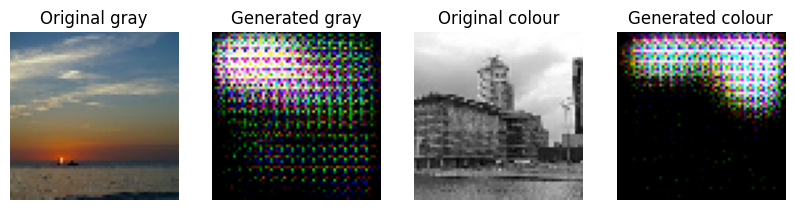

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
Batchs:   0%|          | 0/25 [00:00<?, ?it/s]

1/1 [==============================] - 0s 373ms/step



Batchs:   4%|▍         | 1/25 [00:14<05:44, 14.37s/it]

>1, dA[0.488 ,0.155 ] dB[0.135 ,0.328] g[11.483 ,11.847]
1/1 [==============================] - 0s 372ms/step



Batchs:   8%|▊         | 2/25 [00:28<05:23, 14.05s/it]

>2, dA[1.513 ,0.776 ] dB[4.337 ,0.271] g[17.267 ,15.081]
1/1 [==============================] - 0s 384ms/step



Batchs:  12%|█▏        | 3/25 [00:45<05:42, 15.56s/it]

>3, dA[5.128 ,0.589 ] dB[0.345 ,2.753] g[15.729 ,12.807]
1/1 [==============================] - 0s 384ms/step



Batchs:  16%|█▌        | 4/25 [01:02<05:39, 16.19s/it]

>4, dA[1.164 ,1.601 ] dB[0.761 ,0.694] g[13.959 ,17.432]
1/1 [==============================] - 0s 383ms/step



Batchs:  20%|██        | 5/25 [01:16<05:09, 15.48s/it]

>5, dA[6.855 ,0.899 ] dB[0.760 ,2.047] g[16.376 ,14.675]
1/1 [==============================] - 0s 362ms/step



Batchs:  24%|██▍       | 6/25 [01:33<05:04, 16.02s/it]

>6, dA[5.720 ,0.635 ] dB[0.763 ,1.624] g[13.908 ,13.390]
1/1 [==============================] - 0s 391ms/step



Batchs:  28%|██▊       | 7/25 [01:48<04:38, 15.46s/it]

>7, dA[0.398 ,0.272 ] dB[0.514 ,0.391] g[10.301 ,10.138]
1/1 [==============================] - 0s 368ms/step



Batchs:  32%|███▏      | 8/25 [02:02<04:15, 15.05s/it]

>8, dA[0.177 ,0.167 ] dB[0.578 ,0.433] g[11.574 ,11.700]
1/1 [==============================] - 0s 379ms/step



Batchs:  36%|███▌      | 9/25 [02:19<04:12, 15.79s/it]

>9, dA[1.392 ,0.367 ] dB[0.293 ,0.693] g[12.053 ,11.644]
1/1 [==============================] - 0s 372ms/step



Batchs:  40%|████      | 10/25 [02:38<04:09, 16.66s/it]

>10, dA[0.303 ,0.086 ] dB[0.549 ,0.162] g[9.548 ,9.771]
1/1 [==============================] - 1s 687ms/step



Batchs:  44%|████▍     | 11/25 [02:52<03:43, 15.95s/it]

>11, dA[0.438 ,0.376 ] dB[0.389 ,0.407] g[10.390 ,10.492]
1/1 [==============================] - 0s 388ms/step



Batchs:  48%|████▊     | 12/25 [03:11<03:39, 16.88s/it]

>12, dA[0.416 ,0.085 ] dB[0.264 ,0.225] g[11.607 ,12.026]
1/1 [==============================] - 0s 397ms/step



Batchs:  52%|█████▏    | 13/25 [03:29<03:24, 17.01s/it]

>13, dA[0.551 ,0.141 ] dB[0.135 ,0.572] g[9.742 ,11.010]
1/1 [==============================] - 0s 373ms/step



Batchs:  56%|█████▌    | 14/25 [03:43<02:58, 16.23s/it]

>14, dA[2.847 ,0.864 ] dB[0.236 ,0.704] g[11.140 ,10.525]
1/1 [==============================] - 0s 395ms/step



Batchs:  60%|██████    | 15/25 [03:57<02:36, 15.64s/it]

>15, dA[0.852 ,0.128 ] dB[0.494 ,0.178] g[10.735 ,11.844]
1/1 [==============================] - 0s 374ms/step



Batchs:  64%|██████▍   | 16/25 [04:12<02:17, 15.30s/it]

>16, dA[0.681 ,0.070 ] dB[0.465 ,0.133] g[10.558 ,11.431]
1/1 [==============================] - 0s 366ms/step



Batchs:  68%|██████▊   | 17/25 [04:26<01:59, 14.99s/it]

>17, dA[0.302 ,0.065 ] dB[0.033 ,0.382] g[10.044 ,11.178]
1/1 [==============================] - 0s 375ms/step



Batchs:  72%|███████▏  | 18/25 [04:43<01:49, 15.67s/it]

>18, dA[0.087 ,0.044 ] dB[0.104 ,0.226] g[9.318 ,10.471]
1/1 [==============================] - 0s 377ms/step



Batchs:  76%|███████▌  | 19/25 [05:01<01:36, 16.14s/it]

>19, dA[0.165 ,0.145 ] dB[0.170 ,0.151] g[8.714 ,8.639]
1/1 [==============================] - 0s 373ms/step



Batchs:  80%|████████  | 20/25 [05:15<01:17, 15.56s/it]

>20, dA[0.262 ,0.209 ] dB[0.570 ,0.135] g[11.170 ,11.489]
1/1 [==============================] - 0s 389ms/step



Batchs:  84%|████████▍ | 21/25 [05:33<01:05, 16.26s/it]

>21, dA[0.133 ,0.252 ] dB[0.173 ,0.095] g[7.733 ,7.800]
1/1 [==============================] - 0s 387ms/step



Batchs:  88%|████████▊ | 22/25 [05:47<00:46, 15.64s/it]

>22, dA[0.417 ,0.075 ] dB[1.446 ,0.103] g[11.723 ,11.446]
1/1 [==============================] - 0s 375ms/step



Batchs:  92%|█████████▏| 23/25 [06:06<00:33, 16.79s/it]

>23, dA[1.385 ,0.089 ] dB[0.370 ,0.532] g[12.031 ,12.886]
1/1 [==============================] - 1s 683ms/step



Batchs:  96%|█████████▌| 24/25 [06:20<00:15, 15.94s/it]

>24, dA[0.688 ,0.149 ] dB[0.156 ,0.306] g[8.866 ,8.985]
1/1 [==============================] - 1s 672ms/step



Epochs:  67%|██████▋   | 2/3 [15:41<07:38, 458.32s/it]

>25, dA[0.420 ,0.148 ] dB[0.134 ,0.211] g[9.471 ,10.488]



Batchs:   0%|          | 0/25 [00:00<?, ?it/s]

1/1 [==============================] - 0s 373ms/step



Batchs:   4%|▍         | 1/25 [00:17<06:52, 17.19s/it]

>1, dA[0.176 ,0.078 ] dB[0.049 ,0.136] g[8.581 ,9.539]
1/1 [==============================] - 0s 391ms/step



Batchs:   8%|▊         | 2/25 [00:34<06:43, 17.52s/it]

>2, dA[0.100 ,0.287 ] dB[0.125 ,0.081] g[9.402 ,9.547]
1/1 [==============================] - 0s 399ms/step



Batchs:  12%|█▏        | 3/25 [00:53<06:40, 18.22s/it]

>3, dA[1.318 ,0.151 ] dB[0.403 ,0.798] g[14.703 ,12.687]
1/1 [==============================] - 1s 684ms/step



Batchs:  16%|█▌        | 4/25 [01:12<06:26, 18.38s/it]

>4, dA[0.275 ,0.653 ] dB[0.203 ,0.136] g[8.481 ,10.255]
1/1 [==============================] - 0s 392ms/step



Batchs:  20%|██        | 5/25 [01:26<05:37, 16.88s/it]

>5, dA[0.328 ,1.054 ] dB[0.540 ,0.364] g[9.754 ,10.932]
1/1 [==============================] - 0s 376ms/step



Batchs:  24%|██▍       | 6/25 [01:44<05:23, 17.01s/it]

>6, dA[0.098 ,0.352 ] dB[0.851 ,0.088] g[11.142 ,11.252]
1/1 [==============================] - 0s 380ms/step



Batchs:  28%|██▊       | 7/25 [01:58<04:50, 16.16s/it]

>7, dA[0.248 ,0.797 ] dB[0.362 ,0.213] g[11.650 ,12.449]
1/1 [==============================] - 0s 372ms/step



Batchs:  32%|███▏      | 8/25 [02:15<04:41, 16.54s/it]

>8, dA[0.148 ,0.302 ] dB[0.127 ,0.498] g[7.928 ,8.283]
1/1 [==============================] - 0s 386ms/step



Batchs:  36%|███▌      | 9/25 [02:34<04:37, 17.35s/it]

>9, dA[0.192 ,0.154 ] dB[0.080 ,0.176] g[9.740 ,9.791]
1/1 [==============================] - 1s 699ms/step



Batchs:  40%|████      | 10/25 [02:49<04:05, 16.39s/it]

>10, dA[0.353 ,1.566 ] dB[0.301 ,0.256] g[8.784 ,9.417]
1/1 [==============================] - 1s 521ms/step



Batchs:  44%|████▍     | 11/25 [03:03<03:39, 15.71s/it]

>11, dA[1.013 ,1.135 ] dB[0.177 ,0.578] g[10.476 ,10.035]
1/1 [==============================] - 0s 373ms/step



Batchs:  48%|████▊     | 12/25 [03:17<03:17, 15.22s/it]

>12, dA[0.257 ,0.323 ] dB[0.287 ,0.136] g[8.464 ,9.286]
1/1 [==============================] - 0s 366ms/step



Batchs:  52%|█████▏    | 13/25 [03:31<02:58, 14.89s/it]

>13, dA[0.535 ,0.146 ] dB[0.087 ,0.502] g[9.354 ,9.136]
1/1 [==============================] - 0s 388ms/step



Batchs:  56%|█████▌    | 14/25 [03:50<02:56, 16.09s/it]

>14, dA[0.682 ,0.464 ] dB[0.291 ,0.557] g[9.789 ,10.431]
1/1 [==============================] - 1s 678ms/step



Batchs:  60%|██████    | 15/25 [04:09<02:49, 16.98s/it]

>15, dA[0.167 ,0.151 ] dB[0.181 ,0.113] g[8.538 ,8.773]
1/1 [==============================] - 0s 385ms/step



Batchs:  64%|██████▍   | 16/25 [04:26<02:33, 17.01s/it]

>16, dA[0.276 ,0.270 ] dB[0.589 ,0.531] g[10.459 ,10.199]
1/1 [==============================] - 0s 379ms/step



Batchs:  68%|██████▊   | 17/25 [04:40<02:09, 16.18s/it]

>17, dA[3.872 ,0.391 ] dB[0.118 ,0.538] g[12.474 ,12.322]
1/1 [==============================] - 0s 390ms/step



Batchs:  72%|███████▏  | 18/25 [04:55<01:49, 15.60s/it]

>18, dA[0.482 ,0.177 ] dB[0.034 ,0.305] g[8.421 ,9.920]
1/1 [==============================] - 0s 377ms/step



Batchs:  76%|███████▌  | 19/25 [05:12<01:36, 16.07s/it]

>19, dA[0.113 ,0.673 ] dB[1.703 ,0.173] g[11.354 ,13.868]
1/1 [==============================] - 0s 401ms/step



Batchs:  80%|████████  | 20/25 [05:30<01:23, 16.67s/it]

>20, dA[0.107 ,0.310 ] dB[0.430 ,0.442] g[7.896 ,7.646]
1/1 [==============================] - 0s 371ms/step



Batchs:  84%|████████▍ | 21/25 [05:49<01:09, 17.44s/it]

>21, dA[0.077 ,0.341 ] dB[0.226 ,0.122] g[8.389 ,9.078]
1/1 [==============================] - 0s 378ms/step



Batchs:  88%|████████▊ | 22/25 [06:06<00:52, 17.38s/it]

>22, dA[0.046 ,0.783 ] dB[2.824 ,0.573] g[10.415 ,11.627]
1/1 [==============================] - 0s 385ms/step



Batchs:  92%|█████████▏| 23/25 [06:23<00:34, 17.28s/it]

>23, dA[0.250 ,0.135 ] dB[0.574 ,0.825] g[8.924 ,8.745]
1/1 [==============================] - 0s 373ms/step



Batchs:  96%|█████████▌| 24/25 [06:41<00:17, 17.42s/it]

>24, dA[0.156 ,0.105 ] dB[0.114 ,0.280] g[10.975 ,10.583]
1/1 [==============================] - 0s 383ms/step



Epochs: 100%|██████████| 3/3 [22:42<00:00, 454.13s/it]

>25, dA[0.190 ,0.260 ] dB[0.238 ,0.209] g[8.309 ,7.998]


In [ ]:
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator:A->B
g_model_AtoB = define_generator(image_shape)
# generator:B->A
g_model_BtoA = define_generator(image_shape)
# discriminator A-[real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator B-[real/fake]
d_model_B = define_discriminator(image_shape)
# composite : A->B ->[real/fake ,A ]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite : B->A ->[real/fake ,B ]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
train(dataset, d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, epochs=3, chunk=5)

In [ ]:
graytocolour_gen = load_model('/content/Generator_gray_to_colour.h5')
colourtogray_gen = load_model('/content/Generator_colour_to_gray.h5')

1/1 [==============================] - 2s 2s/step


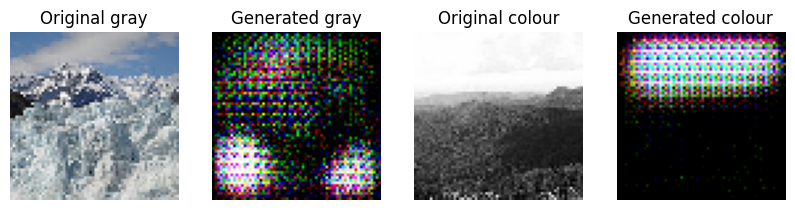

1/1 [==============================] - 0s 380ms/step


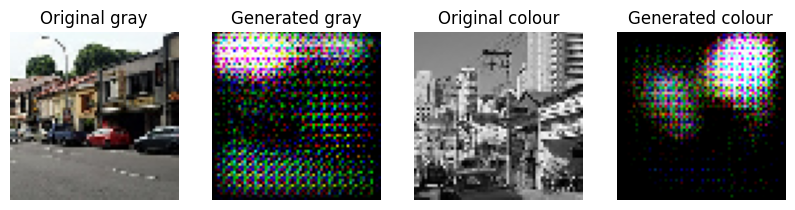

1/1 [==============================] - 0s 378ms/step


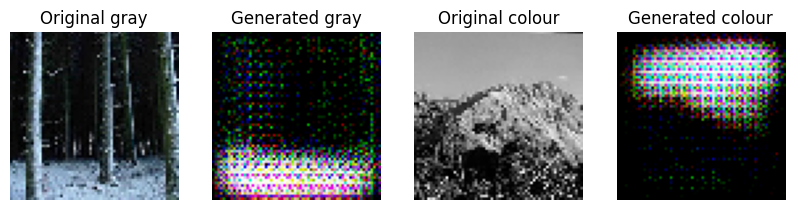

In [ ]:
show_preds(graytocolour_gen,colourtogray_gen ,n_images=3)